<b><h2> LDA Topic Modelling with evaluation metrics </h2></b>

This Jupyter file seeks to run the LDA model with Evaluation metrics to determine the best parameters for LDA configuration. The output of the model will be a HTML file showing the top topics.

<b><h3> Importing the relevant libraries & data preparation</h3></b>

In [1]:
import os
import re
import pandas as pd

<b><h4> Looping through all the txt files containing post description and combining it into one </h4> </b>

In [2]:

import glob

read_files = glob.glob('./*.txt')

with open('result.txt', 'wb') as outfile:
    for f in read_files:
        with open(f, 'rb') as infile:
            outfile.write(infile.read())

<b><h4> Reading the combined txt file of result.txt </b></h4>

In [3]:
df = pd.read_csv('result.txt', sep="\t", header=None, names=["Description"])

<b><h4> Previewing the dataframe </b></h4>

In [4]:
df.head()

,Description
0,Who likes fresh tacky dirt? The Pacific North ...
1,The whole Pacific North West feature including...
2,Sad to see Eliot Jackson leave MTB racing behi...
3,Good times on a photo shoot in Moab a few yeas...
4,Chris Van Dine engulfing himself with evening ...


<b><h3> Remove punctuation and lower casing </b></h3>

In [5]:
# Load the regular expression library
import re

# Remove punctuation
df['df_processed'] = df['Description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['df_processed'] = df['df_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['df_processed'].head()

0    who likes fresh tacky dirt the pacific north w...
1    the whole pacific north west feature including...
2    sad to see eliot jackson leave mtb racing behi...
3    good times on a photo shoot in moab a few yeas...
4    chris van dine engulfing himself with evening ...
Name: df_processed, dtype: object

<b><h3> Basic EDA visualization with WordCloud </b></h3>

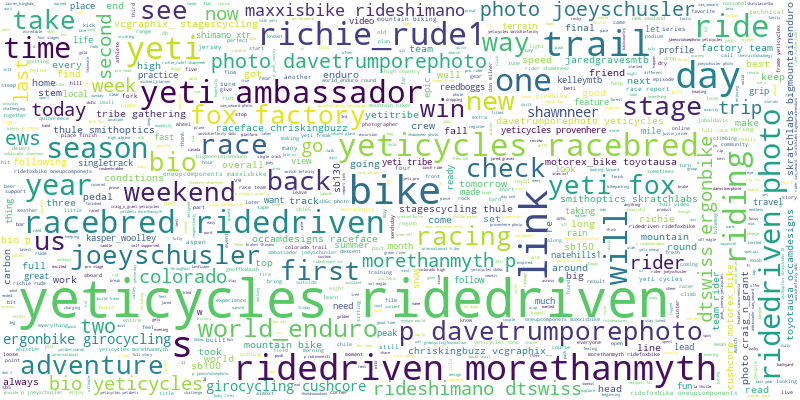

In [29]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['df_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)

# Generate a word cloud
wordcloud.generate(long_string)

wordcloud.to_file('N.png')

# Visualize the word cloud
wordcloud.to_image()

<b><h3> Tokenization and further cleaning up the text</h3></b>

In [6]:
import gensim

from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df.df_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['who', 'likes', 'fresh', 'tacky', 'dirt', 'the', 'pacific', 'north', 'west', 'is', 'full', 'of', 'it', 'view', 'our', 'latest', 'feature', 'video', 'with', 'lfrrude', 'and', 'joeyschusler', 'here', 'vimeocom']


<b><h3> Building Bigram and Trigram Models </h3></b>

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

<b><h4> Remove stopwords, Create Bigram and Trigram and Perform lemmatization</h4></b>

In [8]:
# NLTK Stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'in', 'get', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#!pip install spacy

In [10]:
#!python -m spacy download en_core_web_sm

<b><h4> Run the functions in sequence </h4></b>

In [11]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['like', 'fresh', 'pacific', 'north', 'west', 'full', 'view', 'late', 'feature', 'video', 'lfrrude', 'joeyschusler', 'vimeocom']


<b><h3> Loading Corpus </b></h3>

In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


<b><h4> Running the Base Model </h4></b>

In [13]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [15]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"bike" + 0.013*"trail" + 0.012*"ride" + 0.009*"sendsday" + '
  '0.008*"bar" + 0.007*"yeticycle" + 0.007*"way" + 0.006*"keep" + '
  '0.006*"first" + 0.006*"head"'),
 (1,
  '0.050*"link" + 0.037*"cushcore" + 0.035*"bio" + 0.035*"full" + '
  '0.014*"race_report" + 0.013*"video" + 0.012*"read" + 0.009*"check" + '
  '0.009*"follow" + 0.009*"take"'),
 (2,
  '0.031*"thule" + 0.021*"bike" + 0.014*"ride" + 0.014*"tune" + 0.011*"race" + '
  '0.009*"stem" + 0.008*"trail" + 0.007*"week" + 0.007*"go" + '
  '0.006*"warrenkniss"'),
 (3,
  '0.032*"rideshimano" + 0.012*"shock" + 0.011*"brake" + 0.010*"photo" + '
  '0.009*"yeticycle" + 0.009*"season" + 0.007*"rotor" + 0.007*"ride" + '
  '0.007*"sb" + 0.007*"race"'),
 (4,
  '0.027*"team" + 0.026*"race" + 0.020*"chriskingbuzz" + 0.018*"richie_rude" + '
  '0.014*"day" + 0.013*"stage" + 0.011*"shawnneer" + 0.010*"first" + '
  '0.010*"season" + 0.010*"rider"'),
 (5,
  '0.034*"dtswiss" + 0.032*"raceface" + 0.029*"stagescycle" + '
  '0.027*"oneup

<b><h4> Topics </h4></b>
<ol>
        <li> Bike Trail </li>
        <li> Link </li>
        <li> Bike </li>
        <li> Bike </li>
        <li> Team </li>
        <li> Bike </li>
        <li> Bike </li>
        <li> Bike Trail </li>
        <li> Bike </li>
        <li> Bike Trail</li>
</ol>

<b><h4> Calculating Coherence and Perplexity score </b></h4>

In [16]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Coherence Score:  0.5489638024526802

Perplexity:  -7.779752148170544


<b><h4> Hyperparameter Tuning </b></h4>

In [14]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

<b><h4> Iterate over the range of topics, alpha, and beta parameter values to draw the best params for LDA</h4></b>

In [15]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()


<b><h3> Run the final model with the best Alpha, Beta and Number of Topics K </h3></b>

In [16]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta="symmetric")

<b><h4> Coherence score improved about 24% with this configuration </h4></b>

Previous Coherence: 0.5489638024526802

Current Coherence: 0.674127804

<b><h3> Visualize Topics with pyLDavis </h3></b>

In [23]:
#!pip install pyLDAvis

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Visualize the topics

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#LDAvis_prepared

pyLDAvis.save_html(LDAvis_prepared, "topic_viz_combine-txt2.html")
